In [1]:
from sae_lens import HookedSAETransformer
import torch
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import datasets
from collections import defaultdict
import time
import os
import json

In [2]:
transformer_name = 'gemma-2b'
device = 'cuda'
layer = 14
hook_name = 'blocks.13.hook_resid_pre'
max_length = 1024
full_sequence_batch_size = 4

In [3]:
def get_texts(n_texts):
    data = datasets.load_dataset('NeelNanda/pile-10k')['train']
    texts = []

    for i, t in enumerate(data):
        if len(t['text']) > 6000:
            texts.append(t['text'])

        if len(texts) == n_texts:
            break
    
    if len(texts) < n_texts:
        raise ValueError('not enough texts, only found', len(texts))


    print('went through', i, 'texts')

    return texts

def save_acts(transformer_name, device, layer, hook_name, max_length, full_sequence_batch_size):
    transformer = HookedSAETransformer.from_pretrained(transformer_name, device=device)
    transformer.eval()
    tok = transformer.tokenizer

    texts = get_texts(1024)
    input = tok(texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)

    sequence_acts = []

    with torch.no_grad():
        for i in range(0, input.input_ids.shape[0], full_sequence_batch_size):
            batch = input.input_ids[i:i+full_sequence_batch_size].to(device)
            acts = transformer.run_with_cache(batch, prepend_bos=False, stop_at_layer=layer)[1][hook_name]

            for j in range(batch.shape[0]):
                sequence_acts.append(acts[j].to('cpu'))

    sequence_acts = torch.stack(sequence_acts)

    torch.save(sequence_acts, f'../../cruft/{transformer_name}.pt')

In [4]:
save_acts(
    transformer_name='gemma-2b',
    device='cuda',
    layer=14,
    hook_name='blocks.13.hook_resid_pre',
    max_length=1024,
    full_sequence_batch_size=4
)


save_acts(
    transformer_name='gemma-2-9b',
    device='cuda',
    layer=34,
    hook_name='blocks.33.hook_resid_pre',
    max_length=1024,
    full_sequence_batch_size=1
)

save_acts(
    transformer_name='gpt2',
    device='cuda',
    layer=11,
    hook_name='blocks.10.hook_resid_pre',
    max_length=1024,
    full_sequence_batch_size=16
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer
went through 6197 texts


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b into HookedTransformer
went through 6197 texts
Loaded pretrained model gpt2 into HookedTransformer
went through 6197 texts


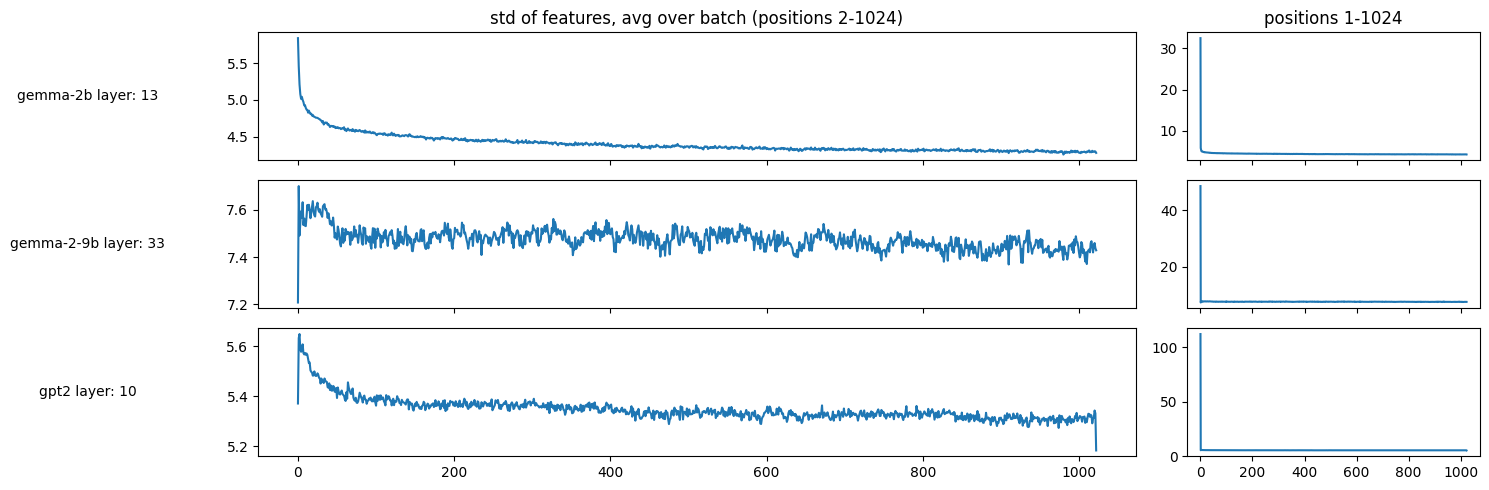

In [35]:
base_names = [
    'gemma-2b',
    'gemma-2-9b',
    'gpt2'
]

layers = {
    'gemma-2b': 13,
    'gemma-2-9b': 33,
    'gpt2': 10
}

f, ax = plt.subplots(len(base_names), 2, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 1]})

for i, name in enumerate(base_names):
    filename = f'../../cruft/{name}.pt'
    activations = torch.load(filename, weights_only=True)

    ax[i][0].plot(activations[:, 1:].std(-1).mean(0))
    ax[i][1].plot(activations.std(-1).mean(0))

    ax[i][0].set_ylabel(name + ' layer: ' + str(layers[name]), rotation=0, labelpad=100, va='center')

    if i == 0:
        ax[i][0].set_title('std of features, avg over batch (positions 2-1024)')
        ax[i][1].set_title('positions 1-1024')
    if i != 2:
        # remove xtick labels
        ax[i][0].set_xticklabels([])
        ax[i][1].set_xticklabels([])


plt.tight_layout()

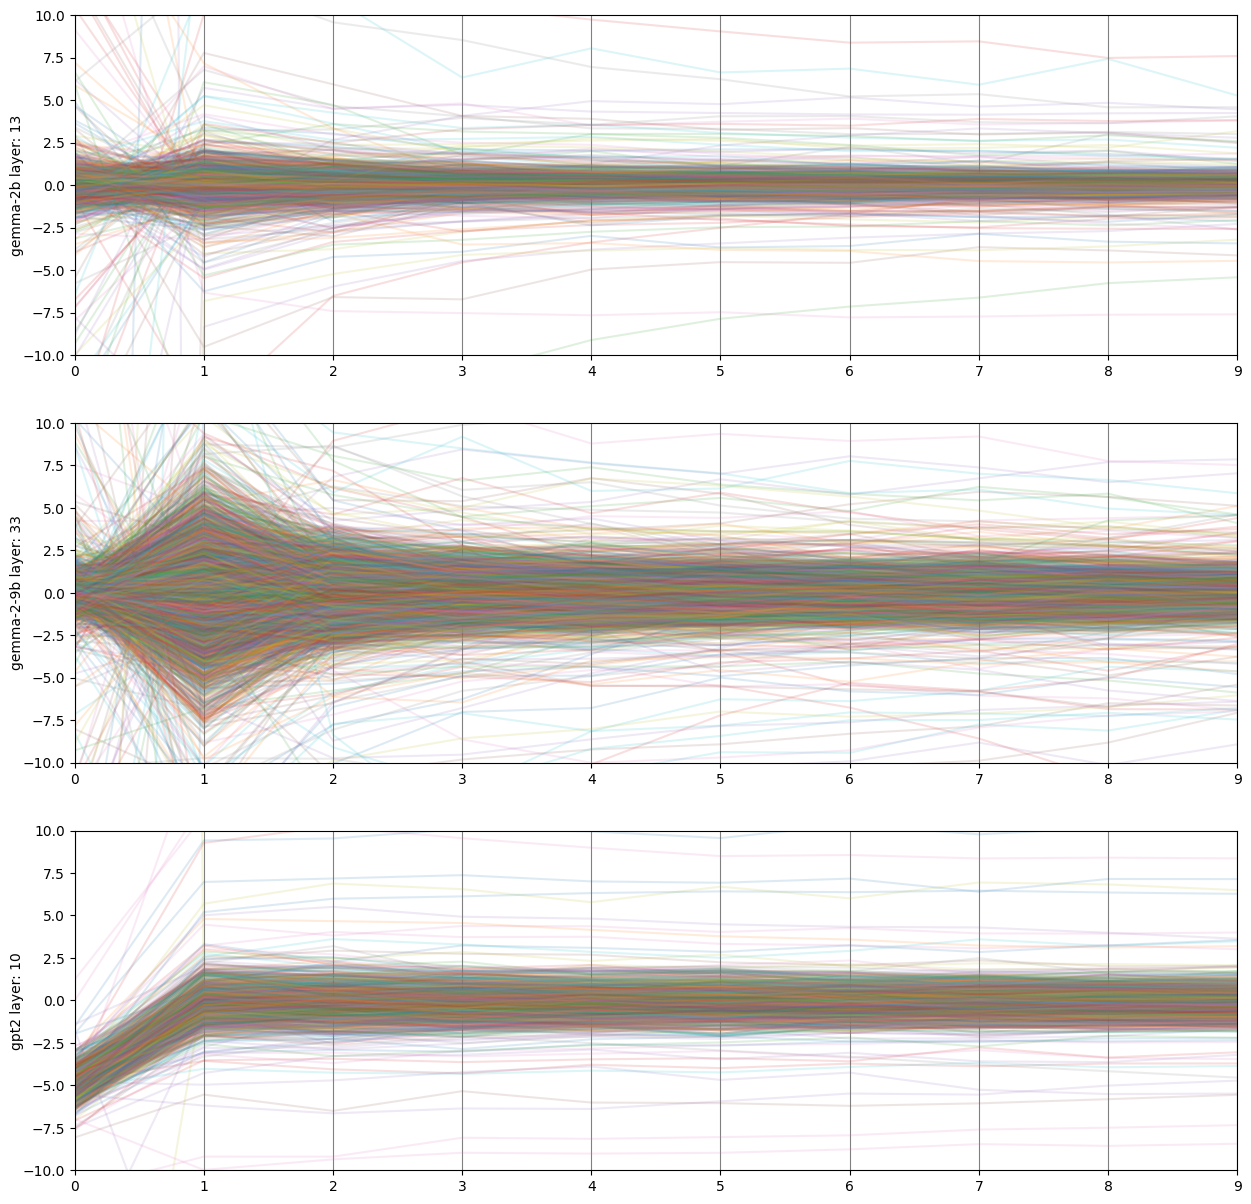

In [53]:
f, ax = plt.subplots(len(base_names), 1, figsize=(15, 15))
for i, name in enumerate(base_names):
    filename = f'../../cruft/{name}.pt'
    activations = torch.load(filename, weights_only=True)

    ax[i].set_ylabel(name + ' layer: ' + str(layers[name]), rotation=90, va='center')

    a = torch.mean(activations, dim=0)

    ax[i].set_ylim(-10, 10)
    for j in range(a.shape[1]):
        ax[i].plot(list(range(10)), a[:10, j], alpha=0.15)

    ax[i].set_xlim(0, 9)
    ax[i].grid(True, which='both', axis='x', color='gray')
